In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Preparing the CIFAR-10 Dataset

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# Loading the datasset
train_dataset = datasets.CIFAR10(root='./data', train=True,download=True, transform = transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download = True, transform=transform)

# Dataloader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:

import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, use_batch_norm=True):
        super(SimpleCNN, self).__init__()
        self.use_batch_norm = use_batch_norm

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_batch_norm else nn.Identity()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()

        # Fully connected layers
        self.relu = nn.ReLU()
        dummy_input = torch.zeros(1, 3, 32, 32)  # CIFAR-10 images are 32x32
        flattened_size = self._get_flattened_size(dummy_input)
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def _get_flattened_size(self, x):
        """Calculate the size of the tensor after all convolutions and pooling."""
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(1, -1).size(1)  # Flatten and return the size

    def forward(self, x):
        """Forward pass for the CNN."""
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x





In [4]:
import torch
import torch.optim as optim
import torch.nn as nn

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 20
early_stopping_patience = 5

criterion = nn.CrossEntropyLoss()  # Loss function

def train_model(model, train_loader, val_loader, use_early_stopping=True, save_path="best_model.pth"):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = float('inf')
    patience = 0
    train_losses = []  # Initialize the list to store training losses
    val_losses = []    # Initialize the list to store validation losses
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if use_early_stopping:
            if val_loss < best_loss:
                best_loss = val_loss
                patience = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience += 1
                if patience >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

    # Load the best model
    if use_early_stopping:
        model.load_state_dict(torch.load(save_path))

    return train_losses, val_losses




In [5]:
# Instantiate the models
model_with_bn = SimpleCNN(use_batch_norm=True)
model_without_bn = SimpleCNN(use_batch_norm=False)

# Train the models
train_losses_bn, val_losses_bn = train_model(model_with_bn, train_loader, val_loader, save_path="model_with_bn.pth")
train_losses_no_bn, val_losses_no_bn = train_model(model_without_bn, train_loader, val_loader, save_path="model_no_bn.pth")

Epoch 1, Train Loss: 1.1741, Val Loss: 0.9399
Epoch 2, Train Loss: 0.8032, Val Loss: 0.8517
Epoch 3, Train Loss: 0.6709, Val Loss: 0.8026
Epoch 4, Train Loss: 0.5757, Val Loss: 0.7493
Epoch 5, Train Loss: 0.4904, Val Loss: 0.7023
Epoch 6, Train Loss: 0.4205, Val Loss: 0.6937
Epoch 7, Train Loss: 0.3533, Val Loss: 0.6477
Epoch 8, Train Loss: 0.3076, Val Loss: 0.6987
Epoch 9, Train Loss: 0.2525, Val Loss: 0.7421
Epoch 10, Train Loss: 0.2168, Val Loss: 0.7894
Epoch 11, Train Loss: 0.1766, Val Loss: 0.8623
Epoch 12, Train Loss: 0.1532, Val Loss: 0.9455
Early stopping triggered


C:\Users\Hp\AppData\Local\Temp\ipykernel_2220\3376273635.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Epoch 1, Train Loss: 1.4337, Val Loss: 1.1331
Epoch 2, Train Loss: 0.9822, Val Loss: 0.9570
Epoch 3, Train Loss: 0.7760, Val Loss: 0.8146
Epoch 4, Train Loss: 0.6448, Val Loss: 0.7323
Epoch 5, Train Loss: 0.5374, Val Loss: 0.7341
Epoch 6, Train Loss: 0.4474, Val Loss: 0.8048
Epoch 7, Train Loss: 0.3663, Val Loss: 0.7914
Epoch 8, Train Loss: 0.2954, Val Loss: 0.8373
Epoch 9, Train Loss: 0.2372, Val Loss: 0.9125
Early stopping triggered


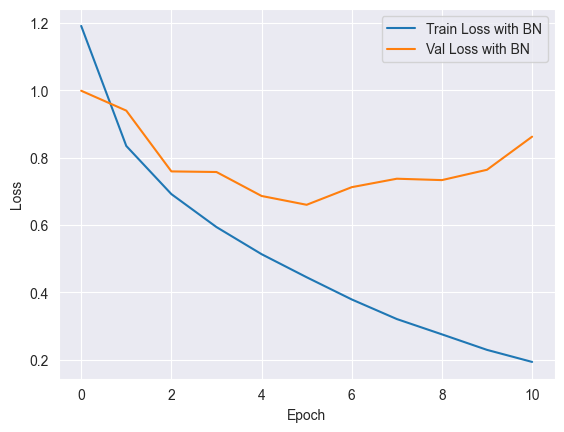

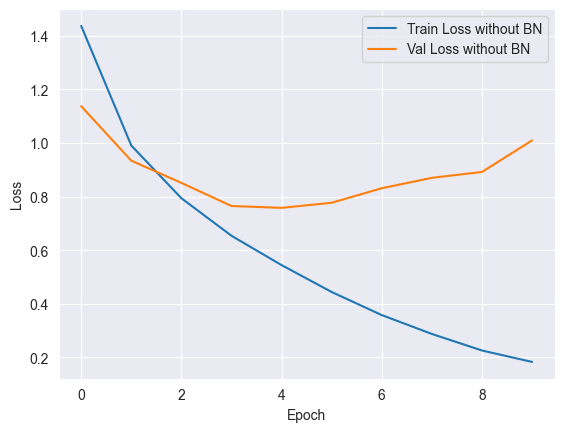

In [24]:
# Plot convergence
plt.plot(train_losses_bn, label="Train Loss with BN")
plt.plot(val_losses_bn, label="Val Loss with BN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.plot(train_losses_no_bn, label="Train Loss without BN")
plt.plot(val_losses_no_bn, label = "Val Loss without BN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].


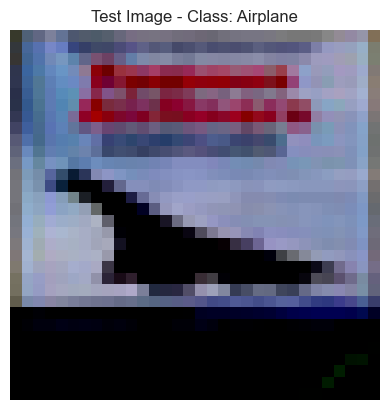

Visualizing filters for layer: conv1


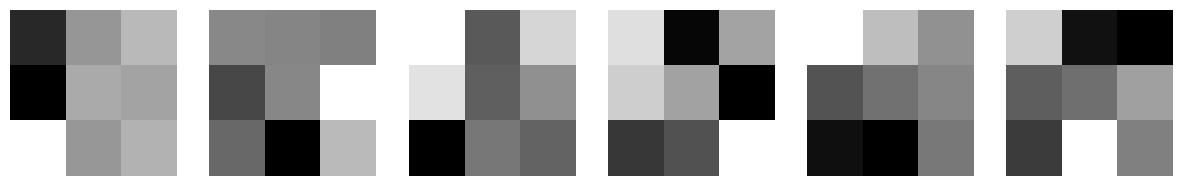

Visualizing filters for layer: conv2


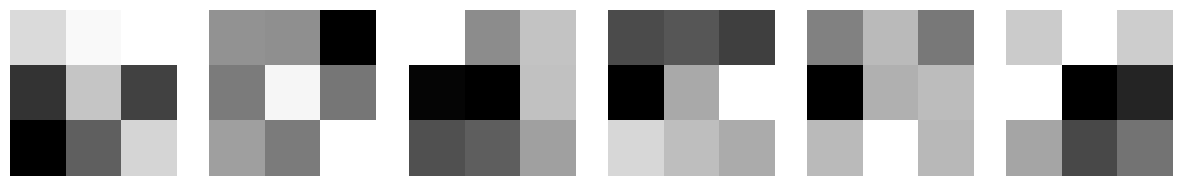

Visualizing filters for layer: conv3


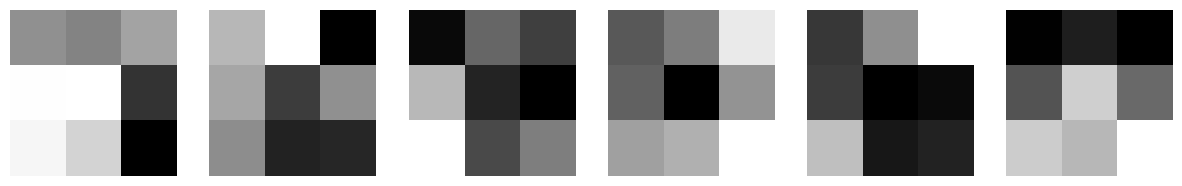

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x16 and 2048x256)

In [25]:
# Visualize features and filters on a test image
def visualize_features_and_filters(model, test_image):


    test_image = test_image.unsqueeze(0)  # Add batch dimension: (C, H, W) -> (1, C, H, W)
    model.eval()

    # Container for storing layer outputs (features)
    features = []

    with torch.no_grad():
        x = test_image
        for name, layer in model.named_children():
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                # Store feature maps
                features.append((name, x))

                # Visualize filters (weights)
                filters = layer.weight.data.cpu().numpy()
                print(f"Visualizing filters for layer: {name}")
                n_filters = min(filters.shape[0], 6)  # Show up to 6 filters
                fig, axs = plt.subplots(1, n_filters, figsize=(15, 5))
                for i in range(n_filters):
                    axs[i].imshow(filters[i][0, :, :], cmap='gray')
                    axs[i].axis('off')
                plt.show()

    # Visualize feature maps
    for name, feature_map in features:
        print(f"Visualizing feature maps for layer: {name}")
        n_channels = min(feature_map.size(1), 6)  # Show up to 6 feature maps
        fig, axs = plt.subplots(1, n_channels, figsize=(15, 15))
        for i, ax in enumerate(axs):
            ax.imshow(feature_map[0, i].cpu(), cmap="viridis")
            ax.axis('off')
        plt.show()

# Select and visualize an airplane image from the validation dataset
airplane_label = 0  # CIFAR-10 label for airplane
test_image = None

for idx, (image, label) in enumerate(val_dataset):
    if label == airplane_label:
        test_image = image
        break

if test_image is not None:
    # Visualize the selected image
    plt.imshow(test_image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for display
    plt.title("Test Image - Class: Airplane")
    plt.axis('off')
    plt.show()

    # Pass the 4D image to the visualization function
    visualize_features_and_filters(model_with_bn, test_image)
else:
    print("No airplane image found in the dataset.")
